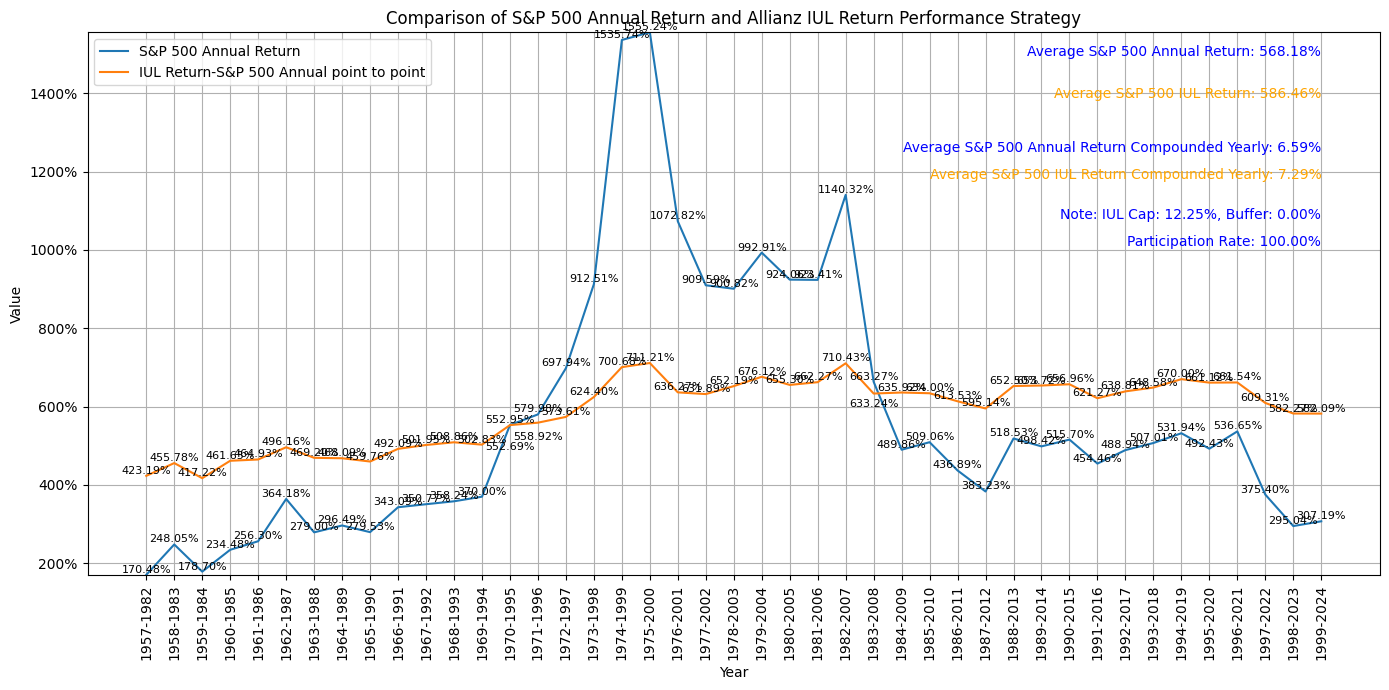

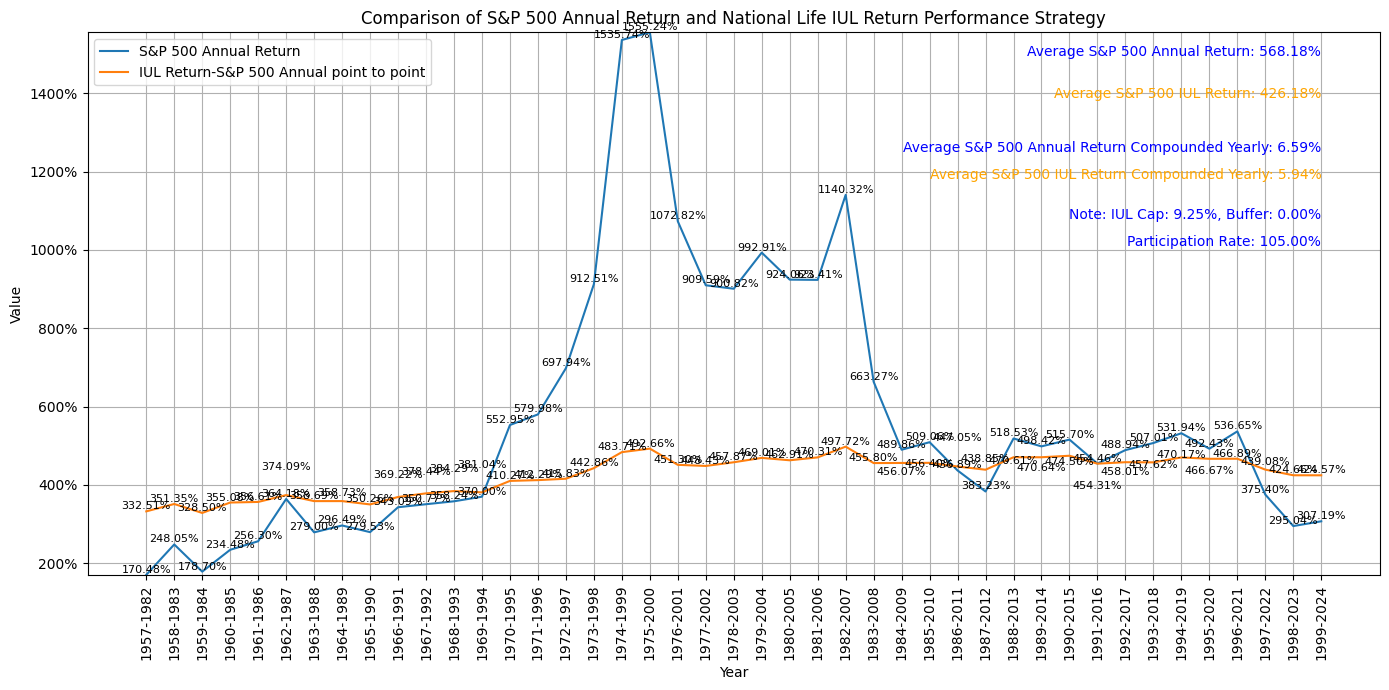

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data1 = pd.read_csv('new_S&P500-raw_prices.csv')
data1 = data1[['Price', 'Close']]
data1 = data1.iloc[2:]
data1['Price'] = pd.to_datetime(data1['Price'])
data1.set_index('Price', inplace=True)
full_date_range = pd.date_range(start=data1.index.min(), end=data1.index.max(), freq='D')
data1 = data1.reindex(full_date_range)
data1.ffill(inplace=True)
data1.reset_index(inplace=True)
data1.rename(columns={'index': 'Date'}, inplace=True)
data1.rename(columns={'Close': 'S&P500'}, inplace=True)

data1['S&P500'] = pd.to_numeric(data1['S&P500'], errors='coerce')

def RILAcapBuffer(data, start_year, end_year, cap, typef, buffer, duration, participationRate = 1,filename = "SP500"):

    startyear = start_year
    # Set index and convert date column to datetime
    data.set_index('Date', inplace=True)
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'])

    RILA = []
    #curRILA = 1
    CAGR = []

    while start_year + duration <= end_year:
        newstartyear = start_year
        increase = 1
        while newstartyear < start_year + duration:
            CurYearData = data[data['Date'].dt.year == newstartyear]
            CurYearData.reset_index(inplace=True)
            CurYearData = CurYearData['S&P500']
            NextYearData = data[data['Date'].dt.year == newstartyear + 1]
            NextYearData.reset_index(inplace=True)
            NextYearData = NextYearData['S&P500']
            totalInc = 0
            for i in range(0, len(CurYearData) - 1):
                inc = NextYearData[i] / CurYearData[i] - 1
                if inc <= 0: 
                    inc = 0
                elif inc > 0:
                    inc = inc * participationRate
                    if inc > cap:
                        inc = cap
                totalInc += inc
            totalInc /= len(NextYearData)
            increase = increase * (1+totalInc)
            newstartyear += 1
            
        #curRILA *= (1 + totalInc)
        RILA.append(increase * 100)
        start_year += 1

    start_year = startyear  # Reset start_year to its initial value
    yearList = []
    while start_year + duration <= end_year:
        endYear = start_year + duration
        yearList.append(f"{start_year}-{endYear}")
        CurYearData = data[data['Date'].dt.year == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['S&P500']
        NextYearData = data[data['Date'].dt.year == endYear]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['S&P500']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = ((NextYearData[i] / CurYearData[i]) - 1) * 100
            totalInc += inc
        CAGR.append(totalInc / len(NextYearData))
        start_year += 1


    # Plot results
    plt.figure(figsize=(14, 7))

    # Add labels for CAGR
    avg_CAGR = np.mean(CAGR)
    avg_RILAout = np.mean(RILA)
    CompoundedCAGR = [(value/100) ** (1/25) - 1 for value in CAGR]
    CompoundedRILA = [(value/100) ** (1/25) - 1 for value in RILA]
    avg_yearlyCAGR = np.mean(CompoundedCAGR) * 100
    avg_yearlyRILAout = np.mean(CompoundedRILA) * 100
    ymax = max(np.max(CAGR), np.max(RILA))
    ymin = min(np.min(CAGR), np.min(RILA))
    comp = (ymax - ymin) / 20

    for i, txt in enumerate(CAGR):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
    for i, txt in enumerate(RILA):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i] - comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i] + comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    # Add labels for RILA
    # for i, txt in enumerate(RILA):
    #     curdif = RILA[i] - comp[i]
    #     plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    if cap >= 50:
        plt.text(yearList[-1], ymax - 7 * comp, f'Note: IUL Cap: Unlimited, Buffer: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    else:
        plt.text(yearList[-1], ymax - 7 * comp, f'Note: IUL Cap: {cap*100:.2f}%, Buffer: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)

    plt.title(f'Comparison of {typef} Annual Return and '+filename +' IUL Return Performance Strategy')
    plt.plot(yearList, CAGR, label=f'{typef} Annual Return')
    plt.plot(yearList, RILA, label=f'IUL Return-{typef} Annual point to point')
    plt.text(yearList[-1], ymax - comp, f'Average {typef} Annual Return: {avg_CAGR:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 8 * comp, f'Participation Rate: {participationRate*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 2 * comp, f'Average {typef} IUL Return: {avg_RILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)
    plt.text(yearList[-1], ymax - 5 * comp, f'Average {typef} IUL Return Compounded Yearly: {avg_yearlyRILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)
    plt.text(yearList[-1], ymax - 4 * comp, f'Average {typef} Annual Return Compounded Yearly: {avg_yearlyCAGR:.2f}%', color='blue', ha='right', va='top', fontsize=10)

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.ylim(ymin, ymax)
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    plt.show()

    CAGR = [f"{value:.2f}%" for value in CAGR]
    RILA = [f"{value:.2f}%" for value in RILA]
    CompoundedCAGR = [f"{value * 100:.2f}%" for value in CompoundedCAGR]
    CompoundedRILA = [f"{value * 100:.2f}%" for value in CompoundedRILA]
    if cap >= 50:
        newData = {
            "Year List": yearList,
            f"Average {typef} Return": CAGR,
            f"Average {typef} Annual Return": CompoundedCAGR,
            f'Average {typef} IUL Return': RILA,
            f'Average {typef} IUL Compounded Return': CompoundedRILA,
            f'Note: IUL Cap: Unlimited, Buffer: {buffer*100:.2f}%': [""] * len(RILA),
            f'Compounded Average {typef} Annual Return': [f'{avg_yearlyCAGR*100:.2f}%'] + [""] * (len(RILA)-1),
            f'Compounded Average {typef} IUL Return': [f'{avg_yearlyRILAout*100:.2f}%'] + [""] * (len(RILA)-1),
        }
    else:
        newData = {
            "Year List": yearList,
            f"Average {typef} Return": CAGR,
            f"Average {typef} Annual Return": CompoundedCAGR,
            f'Average {typef} IUL Return': RILA,
            f'Average {typef} IUL Compounded Return': CompoundedRILA,
            f'Note: IUL Cap: {cap*100:.2f}%, Buffer: {buffer*100:.2f}%': [""] * len(RILA),
            f'Compounded Average {typef} Annual Return': [f'{avg_yearlyCAGR:.2f}%'] + [""] * (len(RILA)-1),
            f'Compounded Average {typef} IUL Return': [f'{avg_yearlyRILAout:.2f}%'] + [""] * (len(RILA)-1),
        }
    df = pd.DataFrame(newData)
    df.to_excel(filename + ' Higher Return.xlsx', engine='openpyxl', index=False)

RILAcapBuffer(data1, 1957, 2024, 0.1225, 'S&P 500', 0, 25, 1.00, "Allianz")
RILAcapBuffer(data1, 1957, 2024, 0.0925, 'S&P 500', 0, 25, 1.05, "National Life")

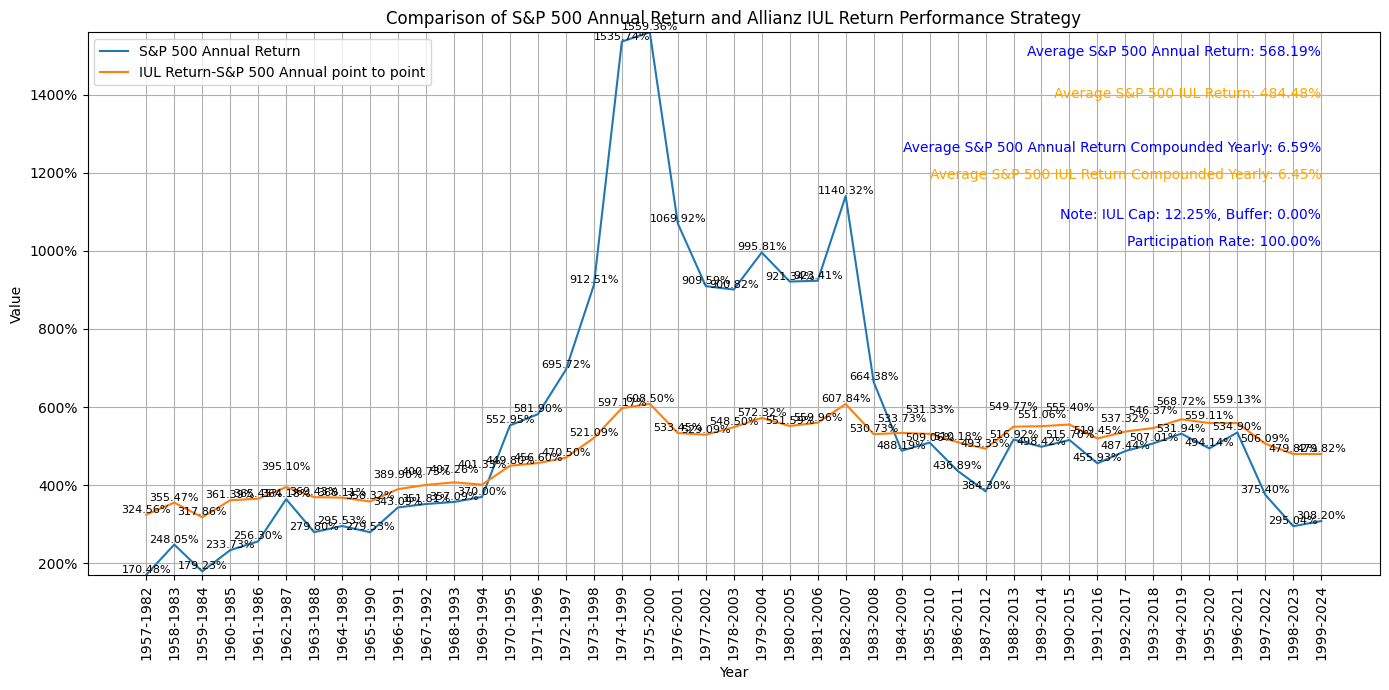

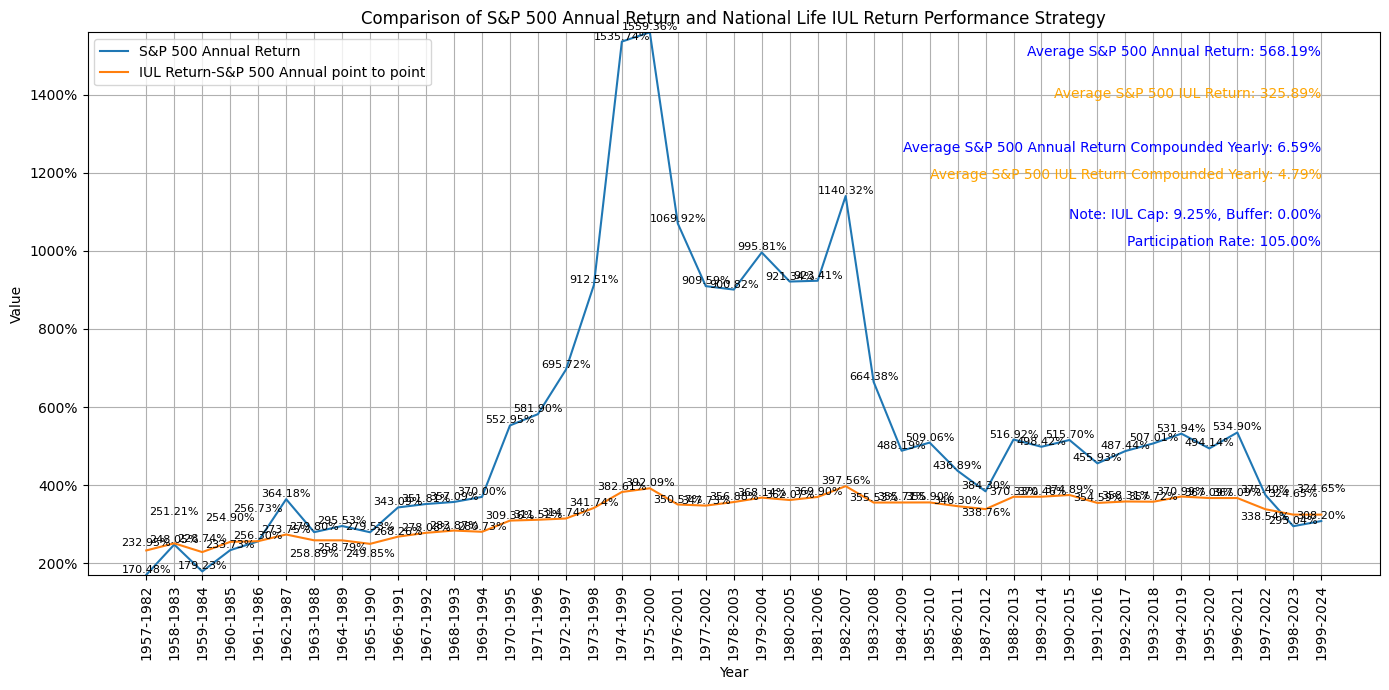

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data1 = pd.read_csv('new_S&P500-raw_prices.csv')
data1 = data1[['Price', 'Close']]
data1 = data1.iloc[2:]
data1['Price'] = pd.to_datetime(data1['Price'])
data1.set_index('Price', inplace=True)
full_date_range = pd.date_range(start=data1.index.min(), end=data1.index.max(), freq='D')
data1 = data1.reindex(full_date_range)
data1.ffill(inplace=True)
data1.reset_index(inplace=True)
data1.rename(columns={'index': 'Date'}, inplace=True)
data1.rename(columns={'Close': 'S&P500'}, inplace=True)
data1 = data1[~((data1['Date'].dt.month == 2) & (data1['Date'].dt.day == 29))]

data1['S&P500'] = pd.to_numeric(data1['S&P500'], errors='coerce')

def RILAcapBuffer(data, start_year, end_year, cap, typef, buffer, duration, participationRate = 1, filename = "SP500"):

    startyear = start_year
    # Set index and convert date column to datetime
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['DayOfYear'] = data['Date'].dt.dayofyear
    data = data[['Year', 'DayOfYear', 'S&P500']]

    RILA = []
    #curRILA = 1
    CAGR = []
    pivot = data.pivot(index='DayOfYear', columns='Year', values='S&P500')
    for base_year in range(start_year, end_year - duration + 1):
        valid_days = pivot.dropna(subset=range(base_year, base_year + duration + 1)).index
        total_path_returns = []
        
        for day in valid_days:
            compounded = 1
            valid = True
            for yr in range(base_year, base_year + duration):
                p0 = pivot.at[day, yr]
                p1 = pivot.at[day, yr + 1]
                inc = (p1 / p0) - 1

                if inc <= 0:
                    inc = 0
                else:
                    inc *= participationRate
                    if inc > cap:
                        inc = cap

                compounded *= (1 + inc)
            if valid:
                total_path_returns.append(compounded - 1)
        #print(len(total_path_returns))
        avg_return = np.mean(total_path_returns) if total_path_returns else np.nan
        RILA.append(avg_return * 100)

    start_year = startyear  # Reset start_year to its initial value
    yearList = []
    while start_year + duration <= end_year:
        endYear = start_year + duration
        yearList.append(f"{start_year}-{endYear}")
        CurYearData = data[data['Year'] == start_year]
        CurYearData.reset_index(inplace=True)
        CurYearData = CurYearData['S&P500']
        NextYearData = data[data['Year'] == endYear]
        NextYearData.reset_index(inplace=True)
        NextYearData = NextYearData['S&P500']
        totalInc = 0
        for i in range(0, len(CurYearData) - 1):
            inc = ((NextYearData[i] / CurYearData[i]) - 1) * 100
            totalInc += inc
        CAGR.append(totalInc / len(NextYearData))
        start_year += 1


    # Plot results
    plt.figure(figsize=(14, 7))

    # Add labels for CAGR
    avg_CAGR = np.mean(CAGR)
    avg_RILAout = np.mean(RILA)
    CompoundedCAGR = [(value/100) ** (1/25) - 1 for value in CAGR]
    CompoundedRILA = [(value/100) ** (1/25) - 1 for value in RILA]
    avg_yearlyCAGR = np.mean(CompoundedCAGR) * 100
    avg_yearlyRILAout = np.mean(CompoundedRILA) * 100
    ymax = max(np.max(CAGR), np.max(RILA))
    ymin = min(np.min(CAGR), np.min(RILA))
    comp = (ymax - ymin) / 20

    for i, txt in enumerate(CAGR):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], CAGR[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
    for i, txt in enumerate(RILA):
        curdif = CAGR[i] - RILA[i]
        if curdif > 0 and curdif < comp:
            plt.text(yearList[i], CAGR[i] - comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        elif curdif < 0 and curdif > - comp:
            plt.text(yearList[i], CAGR[i] + comp, f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)
        else:
            plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    # Add labels for RILA
    # for i, txt in enumerate(RILA):
    #     curdif = RILA[i] - comp[i]
    #     plt.text(yearList[i], RILA[i], f'{txt:.2f}%', ha='center', va='bottom', fontsize=8)

    if cap >= 50:
        plt.text(yearList[-1], ymax - 7 * comp, f'Note: IUL Cap: Unlimited, Buffer: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    else:
        plt.text(yearList[-1], ymax - 7 * comp, f'Note: IUL Cap: {cap*100:.2f}%, Buffer: {buffer*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)

    plt.title(f'Comparison of {typef} Annual Return and '+filename +' IUL Return Performance Strategy')
    plt.plot(yearList, CAGR, label=f'{typef} Annual Return')
    plt.plot(yearList, RILA, label=f'IUL Return-{typef} Annual point to point')
    plt.text(yearList[-1], ymax - comp, f'Average {typef} Annual Return: {avg_CAGR:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 8 * comp, f'Participation Rate: {participationRate*100:.2f}%', color='blue', ha='right', va='bottom', fontsize=10)
    plt.text(yearList[-1], ymax - 2 * comp, f'Average {typef} IUL Return: {avg_RILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)
    plt.text(yearList[-1], ymax - 5 * comp, f'Average {typef} IUL Return Compounded Yearly: {avg_yearlyRILAout:.2f}%', color='orange', ha='right', va='top', fontsize=10)
    plt.text(yearList[-1], ymax - 4 * comp, f'Average {typef} Annual Return Compounded Yearly: {avg_yearlyCAGR:.2f}%', color='blue', ha='right', va='top', fontsize=10)

    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
    plt.ylim(ymin, ymax)
    plt.tight_layout()  # Adjust layout to make room for x-axis labels
    plt.show()

    CAGR = [f"{value:.2f}%" for value in CAGR]
    RILA = [f"{value:.2f}%" for value in RILA]
    CompoundedCAGR = [f"{value * 100:.2f}%" for value in CompoundedCAGR]
    CompoundedRILA = [f"{value * 100:.2f}%" for value in CompoundedRILA]
    if cap >= 50:
        newData = {
            "Year List": yearList,
            f"Average {typef} Return": CAGR,
            f"Average {typef} Annual Return": CompoundedCAGR,
            f'Average {typef} IUL Return': RILA,
            f'Average {typef} IUL Compounded Return': CompoundedRILA,
            f'Note: IUL Cap: Unlimited, Buffer: {buffer*100:.2f}%': [""] * len(RILA),
            f'Compounded Average {typef} Annual Return': [f'{avg_yearlyCAGR*100:.2f}%'] + [""] * (len(RILA)-1),
            f'Compounded Average {typef} IUL Return': [f'{avg_yearlyRILAout*100:.2f}%'] + [""] * (len(RILA)-1),
        }
    else:
        newData = {
            "Year List": yearList,
            f"Average {typef} Return": CAGR,
            f"Average {typef} Annual Return": CompoundedCAGR,
            f'Average {typef} IUL Return': RILA,
            f'Average {typef} IUL Compounded Return': CompoundedRILA,
            f'Note: IUL Cap: {cap*100:.2f}%, Buffer: {buffer*100:.2f}%': [""] * len(RILA),
            f'Compounded Average {typef} Annual Return': [f'{avg_yearlyCAGR:.2f}%'] + [""] * (len(RILA)-1),
            f'Compounded Average {typef} IUL Return': [f'{avg_yearlyRILAout:.2f}%'] + [""] * (len(RILA)-1),
        }
    df = pd.DataFrame(newData)
    df.to_excel(filename+' True Return.xlsx', engine='openpyxl', index=False)

RILAcapBuffer(data1, 1957, 2024, 0.1225, 'S&P 500', 0, 25, 1.00, "Allianz")
RILAcapBuffer(data1, 1957, 2024, 0.0925, 'S&P 500', 0, 25, 1.05, "National Life")
